# Implementation of DLRM (Full/Faktor 2/FedAvg) 

## Imports

In [9]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -q

import tensorflow as tf
from tensorflow.keras.metrics import AUC
# syft absolute
import syft as sy

sy.requires(SYFT_VERSION)

import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


✅ The installed version of syft==0.8.4 matches the requirement >=0.8.2b0 and the requirement <0.9


## Load and preprocess the data

In [10]:
# Load the dataset and fill the nan with 0
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]
df = pd.read_csv('/Users/alex/Thesis/New Dataset/train.txt', sep='\t', names=columns).fillna(0)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,0.0,2,0.0,2.0,41171.0,90.0,0.0,2.0,47.0,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,0.0,3,7.0,10.0,3912.0,400.0,2.0,17.0,104.0,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,0.0,1,48.0,0.0,17375.0,0.0,0.0,0.0,0.0,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,0.0,0,49.0,2.0,16610.0,0.0,0.0,6.0,0.0,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [11]:
# Preprocess Dense Features
dense_cols = [c for c in columns if 'I' in c]
df[dense_cols] = preprocessing.StandardScaler().fit_transform(df[dense_cols])
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [12]:
# Preprocess Categorical Features
cat_cols = [c for c in columns if 'C' in c]
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, df[col].unique()), cat_cols)
}
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping.get)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,0,0,0,0,0,0,0,0,0,0
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,1,1,0,1,1,0,0,1,0,1
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,2,2,1,2,2,1,0,2,1,2
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,3,3,1,2,3,0,0,3,1,2
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,3,4,1,2,4,0,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,1,246,1,2,4,0,1,4,1,2
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,0,21,1,2,144,0,1,20,1,2
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,0,88,96,3,315255,0,1,2096,11,5419
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,3,49,73,3,315256,0,8,29121,3,22213


In [13]:
label_counts = df.groupby('label')['I1'].count()
print(f'Baseline: {max(label_counts.values) / sum(label_counts.values) * 100}%')

Baseline: 74.63203317288634%


In [26]:
# Select halfway point for the split
split_point = len(df) // 2

# Amplify integer features in the first half by multiplying by 2
df.loc[:split_point, 'I1':'I13'] *= 2

# Dampen those integer features in the second half by dividing by 2
df.loc[split_point:, 'I1':'I13'] /= 2

# Now split the DataFrame into two parts: one with amplified features and one with dampened features
df1 = df.iloc[:split_point].reset_index(drop=True)
df2 = df.iloc[split_point:].reset_index(drop=True)

# Verifying the manipulation
print(f"Total records: {len(df)}")
print(f"df1 records: {len(df1)} - with amplified features")
print(f"df2 records: {len(df2)} - with dampened features")

Total records: 1364729
df1 records: 682364 - with amplified features
df2 records: 682365 - with dampened features


In [7]:
dense_cols = [c for c in df.columns if 'I' in c]
cat_cols = [c for c in df.columns if 'C' in c]
fixed_embedding_size = 455000
emb_counts = [len(df[c].unique()) for c in cat_cols]

## Data Owner 1

In [8]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [9]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [10]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [11]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 257s 58ms/step - loss: 0.5176 - accuracy: 0.7597 - auc: 0.8225 - val_loss: 0.4879 - val_accuracy: 0.7683 - val_auc: 0.8452
Epoch 2/5
4265/4265 [==============================] - 181s 42ms/step - loss: 0.4647 - accuracy: 0.7817 - auc: 0.8612 - val_loss: 0.4830 - val_accuracy: 0.7727 - val_auc: 0.8498
Epoch 3/5
4265/4265 [==============================] - 200s 47ms/step - loss: 0.4350 - accuracy: 0.7990 - auc: 0.8800 - val_loss: 0.4903 - val_accuracy: 0.7689 - val_auc: 0.8471
Epoch 4/5
4265/4265 [==============================] - 179s 42ms/step - loss: 0.4042 - accuracy: 0.8171 - auc: 0.8976 - val_loss: 0.5079 - val_accuracy: 0.7645 - val_auc: 0.8396
Epoch 5/5
4265/4265 [==============================] - 117s 27ms/step - loss: 0.3752 - accuracy: 0.8327 - auc: 0.9125 - val_loss: 0.5303 - val_accuracy: 0.7587 - val_auc: 0.8307


In [12]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [13]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 10s 6ms/step - loss: 0.5406 - accuracy: 0.7524 - auc: 0.8253
Loss: 0.5405722260475159, Accuracy: 0.7524065971374512, AUC: 0.825320303440094


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.517578,0.759719,0.822494,0.487893,0.768264,0.845250
1,0.464720,0.781689,0.861245,0.482987,0.772697,0.849765
2,0.434976,0.798956,0.880021,0.490338,0.768887,0.847104
3,0.404162,0.817088,0.897623,0.507912,0.764454,0.839570
4,0.375243,0.832652,0.912457,0.530336,0.758702,0.830654


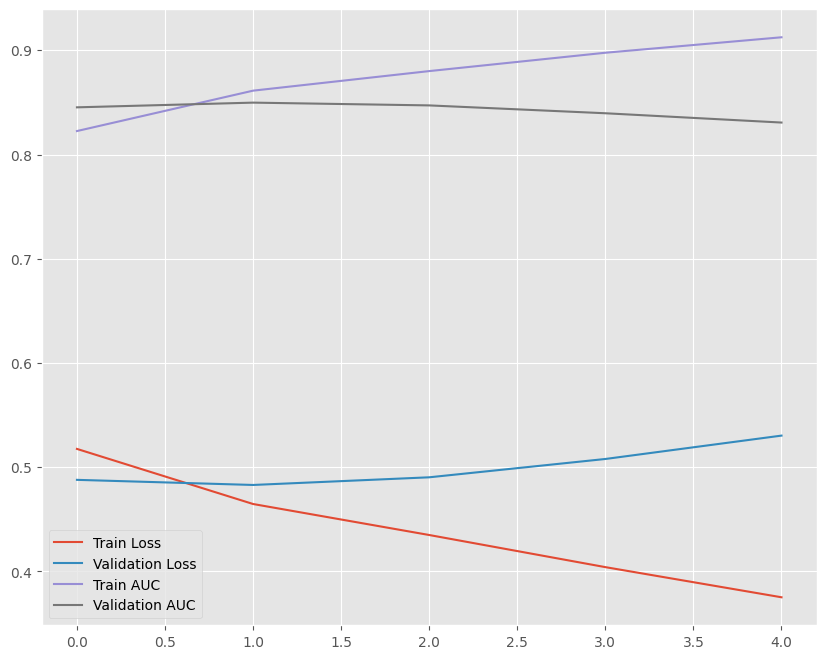

Validation AUC: 0.8304


In [14]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline1 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline1:.4f}")

In [15]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_1 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_1 = add_noise_to_weights(model_weights_dict_1, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [16]:
node = sy.orchestra.launch(name="test-domain-1", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-1 server on 0.0.0.0:25787
Waiting for server to start

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


..........

INFO:     Started server process [44275]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:25787 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=17f0a8cfaf454e40b84edf381b26cbaf in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:52788 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [17]:
domain_client = node.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:52790 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:52790 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-1: High-side Domain> as GUEST
INFO:     127.0.0.1:52790 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:52790 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:52792 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-1: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [18]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_1)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 391adba0c414489195d00e3835c1bf2b


In [19]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:52794 - "POST /api/v2/api_call HTTP/1.1" 200 OK
391adba0c414489195d00e3835c1bf2b


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [20]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:52809 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52811 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [21]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/ba6577f84f4c4037966302d18e87f26b.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=a77805c5ade747dd8e1dbb495ded39b9 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_2722: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:52827 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52830 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_2722
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [22]:
request = domain_client.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:52879 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52882 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:52886 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52888 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52890 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52892 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52894 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52896 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52898 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [23]:
request.approve()

INFO:     127.0.0.1:52882 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:52900 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52902 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52904 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52906 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52908 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52910 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52912 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-1
INFO:     127.0.0.1:52914 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 7b50a09a24134a489bb20a14b4cf463c changes applied

In [24]:
domain_client._api = None
_ = domain_client.api

INFO:     127.0.0.1:52882 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [25]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/938c016356d441a9a7bfed4fe560f8b6.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=3f39671605994a4b9c9fbaf40ab0d680 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_935: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:52930 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52932 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_935
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Exception in thread Thread-10:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/syft_env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/envs/syft_env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/opt/anaconda3/envs/syft_env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/syft_env/lib/python3.9/site-packages/syft/service/queue/zmq_queue.py", line 487, in _run
    self.send_heartbeats()
  File "/opt/anaconda3/envs/syft_env/lib/python3.9/site-packages/syft/service/queue/zmq_queue.py", line 361, in send_heartbeats
    self.send_to_worker(worker, QueueMsgProtocol.W_HEARTBEAT, None, None)
  File "/opt/anaconda3/envs/syft_env/lib/python3.9/site-packages/syft/service/queue/zmq_queue.py", line 456, in send_to_worker
    self.socket.send_multipart(msg)
  File "/opt/anaconda3/envs/syft_env/li

Timeout elapsed after 30 seconds while trying to acquiring lock.
FAILED TO LOCK


Retrieving the Computation Result

Cleanup and Land the Node

In [26]:
if node.node_type.value == "python":
    node.land()

## Data Owner 2

In [27]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [28]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [29]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [30]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 289s 67ms/step - loss: 0.5052 - accuracy: 0.7667 - auc: 0.8326 - val_loss: 0.4756 - val_accuracy: 0.7799 - val_auc: 0.8543
Epoch 2/5
4265/4265 [==============================] - 387s 91ms/step - loss: 0.4595 - accuracy: 0.7864 - auc: 0.8649 - val_loss: 0.4735 - val_accuracy: 0.7805 - val_auc: 0.8561
Epoch 3/5
4265/4265 [==============================] - 378s 89ms/step - loss: 0.4314 - accuracy: 0.8028 - auc: 0.8823 - val_loss: 0.4857 - val_accuracy: 0.7737 - val_auc: 0.8495
Epoch 4/5
4265/4265 [==============================] - 336s 79ms/step - loss: 0.4023 - accuracy: 0.8193 - auc: 0.8987 - val_loss: 0.5095 - val_accuracy: 0.7643 - val_auc: 0.8388
Epoch 5/5
4265/4265 [==============================] - 243s 57ms/step - loss: 0.3751 - accuracy: 0.8334 - auc: 0.9125 - val_loss: 0.5303 - val_accuracy: 0.7613 - val_auc: 0.8344


In [31]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [32]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 13s 9ms/step - loss: 0.5427 - accuracy: 0.7570 - auc: 0.8288
Loss: 0.5427005290985107, Accuracy: 0.7569587826728821, AUC: 0.8288488388061523


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.505221,0.766681,0.832630,0.475573,0.779915,0.854296
1,0.459503,0.786384,0.864902,0.473472,0.780465,0.856081
2,0.431411,0.802758,0.882299,0.485660,0.773723,0.849536
3,0.402314,0.819292,0.898679,0.509463,0.764271,0.838801
4,0.375113,0.833432,0.912528,0.530262,0.761339,0.834395


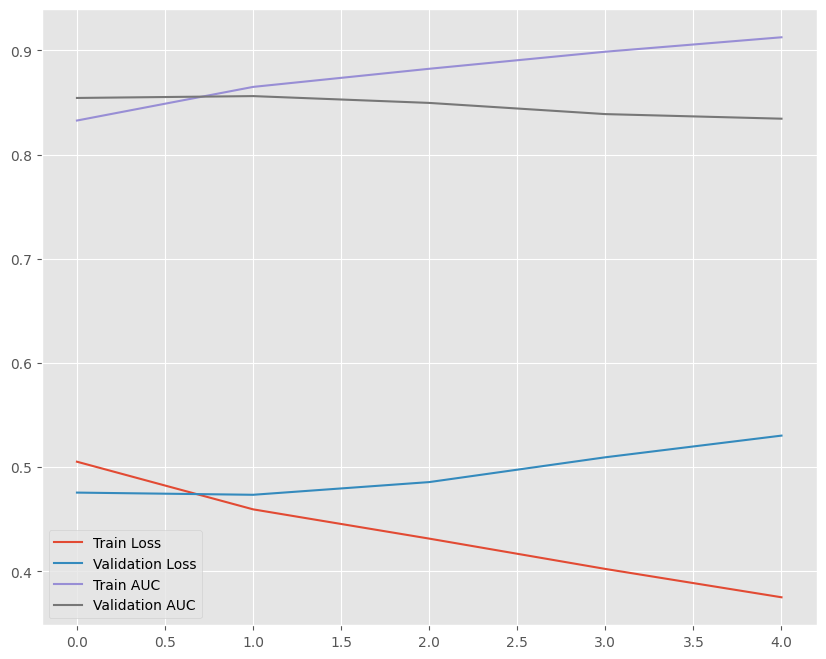

Validation AUC: 0.8352


In [33]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline2 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline2:.4f}")

In [34]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_2 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_2 = add_noise_to_weights(model_weights_dict_2, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [73]:
node_2 = sy.orchestra.launch(name="test-domain-2", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-2 server on 0.0.0.0:33412


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


Waiting for server to start...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/b626124c319343c882a448dac2d6953d.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=add07334572a4f4b904e62532781ee2f in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:55697 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


INFO:     Started server process [45391]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:33412 (Press CTRL+C to quit)


Login to the Domain

In [74]:
domain_client_2 = node_2.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:55699 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:55699 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-2: High-side Domain> as GUEST
INFO:     127.0.0.1:55699 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:55699 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:55701 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-2: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [75]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_2)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> d1510e1aaadd4a43891dd18d2b4e2891


In [76]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client_2.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:55703 - "POST /api/v2/api_call HTTP/1.1" 200 OK
d1510e1aaadd4a43891dd18d2b4e2891


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [77]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:55708 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55710 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55699 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [78]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local_2 = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/14e0ecf4ba0b478da6d5daf9c466b7c2.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=65eb86545bcc41a3b475dff65f522e77 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_1859: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:55715 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55717 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_1859
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [79]:
request = domain_client_2.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:55723 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55725 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:55727 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55729 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55731 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55733 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55735 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55737 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55739 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [80]:
request.approve()

INFO:     127.0.0.1:55725 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:55741 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55743 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55745 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55747 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55749 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55751 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55753 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-2
INFO:     127.0.0.1:55755 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 8cb36a60f4304f249be9cabc3c385933 changes applied

In [81]:
domain_client_2._api = None
_ = domain_client_2.api

INFO:     127.0.0.1:55725 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [82]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local_2 = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/e9536727b9e141af89c1c75ac4248c90.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=b3b7b2aa264946b5ba99b04911bd7ceb in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_141: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:55760 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:55762 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_141
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [83]:
if node_2.node_type.value == "python":
    node_2.land()

## Data Scientist

In [84]:
weights1 = weights_local
weights2 = weights_local_2

In [85]:
import jax.numpy as jnp

def combine_weights(weights1, weights2):
    """Combines two sets of weights by averaging."""
    global_weights = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(weights2.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_weights2 = weights2[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_weights2.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights[key] = (layer_weights1 + layer_weights2) / 2
    
    return global_weights


In [86]:
global_weights = combine_weights(weights1, weights_local_2)

# Data Owner 1 with Global Model Weights 

In [87]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [88]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights:
                sub_layer.set_weights(global_weights[sub_layer.name])
    else:
        if layer.name in global_weights:
            layer.set_weights(global_weights[layer.name])


In [89]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 44s 10ms/step - loss: 0.5220 - accuracy: 0.7575 - auc: 0.8196 - val_loss: 0.4898 - val_accuracy: 0.7649 - val_auc: 0.8437
Epoch 2/5
4265/4265 [==============================] - 46s 11ms/step - loss: 0.4670 - accuracy: 0.7803 - auc: 0.8597 - val_loss: 0.4830 - val_accuracy: 0.7706 - val_auc: 0.8491
Epoch 3/5
4265/4265 [==============================] - 51s 12ms/step - loss: 0.4367 - accuracy: 0.7980 - auc: 0.8790 - val_loss: 0.4896 - val_accuracy: 0.7695 - val_auc: 0.8477
Epoch 4/5
4265/4265 [==============================] - 51s 12ms/step - loss: 0.4059 - accuracy: 0.8156 - auc: 0.8967 - val_loss: 0.5066 - val_accuracy: 0.7658 - val_auc: 0.8408
Epoch 5/5
4265/4265 [==============================] - 60s 14ms/step - loss: 0.3762 - accuracy: 0.8317 - auc: 0.9120 - val_loss: 0.5280 - val_accuracy: 0.7618 - val_auc: 0.8356


In [90]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [91]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 3s 1ms/step - loss: 0.5417 - accuracy: 0.7548 - auc: 0.8287
Loss: 0.5417170524597168, Accuracy: 0.7548338174819946, AUC: 0.8287035226821899


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.521954,0.757549,0.819595,0.489804,0.764893,0.843687
1,0.467013,0.780341,0.859724,0.483038,0.770646,0.849134
2,0.436657,0.797982,0.878979,0.489637,0.769510,0.847703
3,0.405864,0.815610,0.896677,0.506561,0.765846,0.840837
4,0.376211,0.831725,0.911974,0.528045,0.761816,0.835603


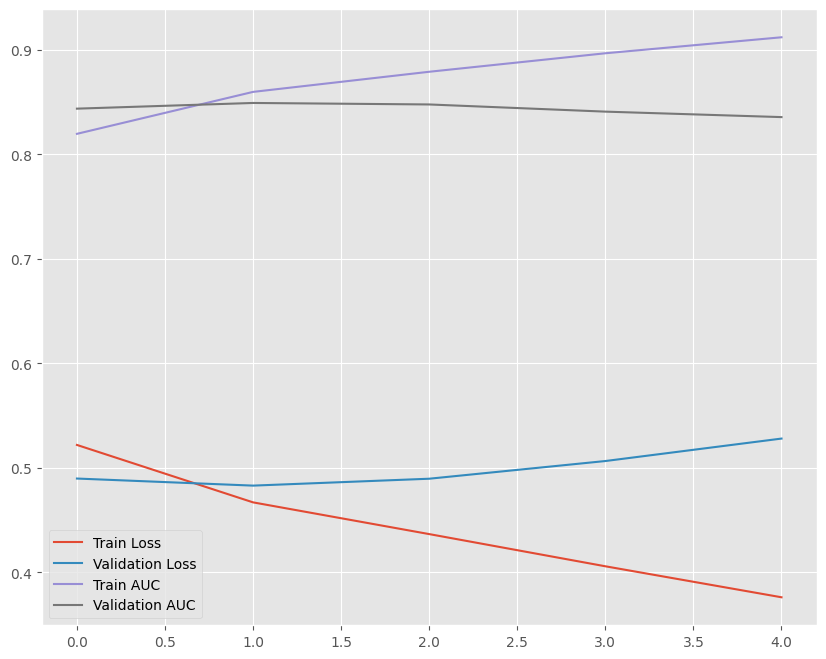

In [92]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [93]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 0.8346


In [94]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline1 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 101.29%


# Data Owner 2 with Global Model Weights 

In [95]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [96]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights:
                sub_layer.set_weights(gglobal_weights[sub_layer.name])
    else:
        if layer.name in global_weights:
            layer.set_weights(global_weights[layer.name])


In [97]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 50s 11ms/step - loss: 0.5122 - accuracy: 0.7635 - auc: 0.8269 - val_loss: 0.4800 - val_accuracy: 0.7770 - val_auc: 0.8511
Epoch 2/5
4265/4265 [==============================] - 49s 11ms/step - loss: 0.4609 - accuracy: 0.7856 - auc: 0.8640 - val_loss: 0.4739 - val_accuracy: 0.7784 - val_auc: 0.8557
Epoch 3/5
4265/4265 [==============================] - 54s 13ms/step - loss: 0.4330 - accuracy: 0.8020 - auc: 0.8815 - val_loss: 0.4836 - val_accuracy: 0.7734 - val_auc: 0.8506
Epoch 4/5
4265/4265 [==============================] - 54s 13ms/step - loss: 0.4042 - accuracy: 0.8183 - auc: 0.8978 - val_loss: 0.5042 - val_accuracy: 0.7659 - val_auc: 0.8420
Epoch 5/5
4265/4265 [==============================] - 53s 12ms/step - loss: 0.3767 - accuracy: 0.8324 - auc: 0.9119 - val_loss: 0.5331 - val_accuracy: 0.7544 - val_auc: 0.8257


In [98]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [99]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 3s 1ms/step - loss: 0.5449 - accuracy: 0.7470 - auc: 0.8195
Loss: 0.5449481010437012, Accuracy: 0.7469843029975891, AUC: 0.8195271492004395


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.512208,0.763536,0.826862,0.480006,0.777021,0.851136
1,0.460915,0.785553,0.864019,0.473897,0.778413,0.855680
2,0.432966,0.802040,0.881494,0.483601,0.773357,0.850612
3,0.404187,0.818316,0.897813,0.504190,0.765883,0.841990
4,0.376678,0.832372,0.911864,0.533099,0.754415,0.825685


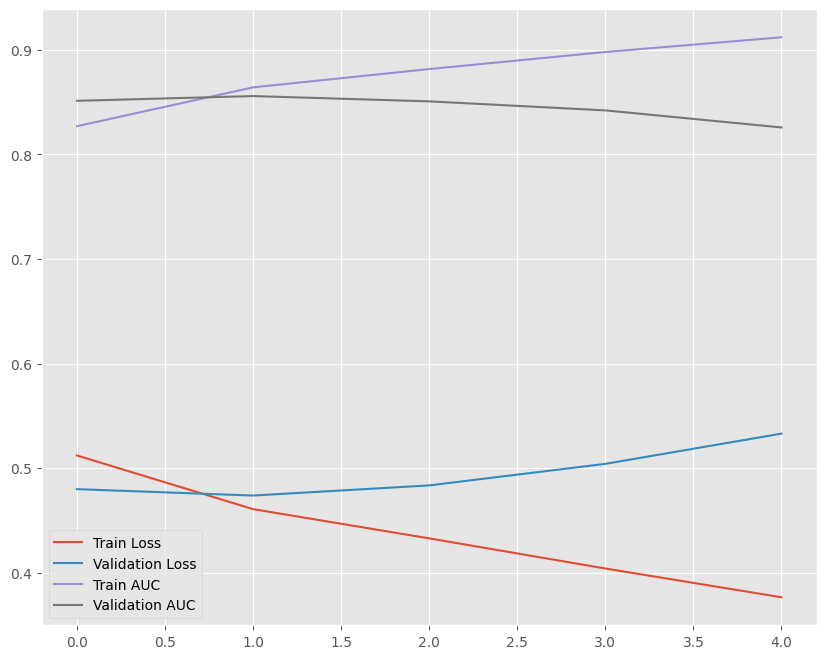

In [100]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [101]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")


Validation AUC: 0.8256


In [102]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline2 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 97.15%
